<h1>First year project 4 - Natural Language Processing <h1>

<h5>jses@itu.dk, vicg@itu.dk, cocr@itu.dk, jacro@itu.dk <h5>

In [1]:
### Imports
import collections
import pickle
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np 
from nltk.tokenize import sent_tokenize, word_tokenize, TweetTokenizer
import nltk
from difflib import SequenceMatcher
import os
from sklearn.metrics import cohen_kappa_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.porter import * # not used afair
import string 

from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn import metrics

In [2]:
#!pip install nlpk
nltk.download('averaged_perceptron_tagger') # IMPORTANT ALSO 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
nltk.download('punkt')
### Paths (you may need to edit these so it fits your base directory)
HATE_PATH = '/work/tweeteval/datasets/hate'
SENTI_PATH = '/work/tweeteval/datasets/sentiment'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
#Function for reading the text files into a list of strings
def read_file(file):
    lines = []
    with open(file, "r") as file:
        lines = file.readlines() #creates list where each entry is a line from file as string
        lines = [line.strip() for line in lines]
        #lines = [line.strip().split(";") for line in lines] #strips end characters i.e. \n and splits on delimiter
    return lines




In [5]:
#Loading data and lowercasing the tweets to follow good practice

hate_train = read_file(f'{HATE_PATH}/train_text.txt')
hate_train = [x.lower() for x in hate_train]
hate_train_labels = read_file(f'{HATE_PATH}/train_labels.txt')
hate_val = read_file(f'{HATE_PATH}/val_text.txt')
hate_val = [x.lower() for x in hate_val]
hate_val_labels=read_file(f'{HATE_PATH}/val_labels.txt')
hate_test = read_file(f'{HATE_PATH}/test_text.txt')
hate_test = [x.lower() for x in hate_test]
hate_test_labels = read_file(f'{HATE_PATH}/test_labels.txt')

senti_train = read_file(f'{SENTI_PATH}/train_text.txt')
senti_train = [x.lower() for x in senti_train]
senti_train_labels = read_file(f'{SENTI_PATH}/train_labels.txt')
senti_val = read_file(f'{SENTI_PATH}/val_text.txt')
senti_val = [x.lower() for x in senti_val]
senti_val_labels = read_file(f'{SENTI_PATH}/val_labels.txt')
senti_test = read_file(f'{SENTI_PATH}/test_text.txt')
senti_test = [x.lower() for x in senti_test]
senti_test_labels = read_file(f'{SENTI_PATH}/test_labels.txt')




In [6]:
#Subset to explore how the tokenizer should work
hate_train_subset = hate_train[0:50]
hate_train_subset


['@user nice new signage. are you not concerned by beatlemania -style hysterical crowds crongregating on you…',
 'a woman who you fucked multiple times saying yo dick small is a compliment you know u hit that spot 😎',
 '@user @user real talk do you have eyes or were they gouged out by a rapefugee?',
 'your girlfriend lookin at me like a groupie in this bitch!',
 'hysterical woman like @user',
 'me flirting- so tell me about your father...',
 'the philippine catholic bishops\' work for migrant workers should focus on families who are "paying the great...',
 "i am not going after your ex bf you lieing sack of shit ! i'm done with you dude that's why i dumped your ass cause your a lieing 😂😡 bitch",
 'when cuffin season is finally over',
 'send home migrants not in need of protection, peter dutton tells un, hey dutton how about the ones that have stayed and not left the country when they should overstayers ? why dont you go and round all them up ?',
 'cory booker and kamala harris competin

In [7]:
#From going through the subset of tweets, we came up with the following issues that needed to be adressed in our tokenizer.

# What do we do with "@user", "#something"
# its vs it is and it's 
# "it's" what do we do with apostrophes?


In [8]:
def preprocess(text_string):
    # whitespace becomes one space only and URLS and twitter mentions are removed.
    space_pat = '\s+'
   # url_pat = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
   #     '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_pat = '@[\w\-]+'
    parsed_text = re.sub(space_pat, ' ', text_string)
   # parsed_text = re.sub(url_pat, '', parsed_text)
    parsed_text = re.sub(mention_pat, '', parsed_text)
    return parsed_text

#use Tokenizer() func instead
def tokenize(tweet):
    tweet = " ".join(re.split(r'\W+', tweet.lower())).strip()
#     tokens = [stemmer.stem(t) for t in tweet.split()] # this caused problems
    tokens = [t for t in tweet.split()] # dropping the Porter stemmer
    return tokens

In [9]:
hate_train_subset_str=' '.join([str(elem) for elem in hate_train_subset])

hate_train_subset_tokenized = tokenize(preprocess(hate_train_subset_str))

hate_train_subset_tokenized

['nice',
 'new',
 'signage',
 'are',
 'you',
 'not',
 'concerned',
 'by',
 'beatlemania',
 'style',
 'hysterical',
 'crowds',
 'crongregating',
 'on',
 'you',
 'a',
 'woman',
 'who',
 'you',
 'fucked',
 'multiple',
 'times',
 'saying',
 'yo',
 'dick',
 'small',
 'is',
 'a',
 'compliment',
 'you',
 'know',
 'u',
 'hit',
 'that',
 'spot',
 'real',
 'talk',
 'do',
 'you',
 'have',
 'eyes',
 'or',
 'were',
 'they',
 'gouged',
 'out',
 'by',
 'a',
 'rapefugee',
 'your',
 'girlfriend',
 'lookin',
 'at',
 'me',
 'like',
 'a',
 'groupie',
 'in',
 'this',
 'bitch',
 'hysterical',
 'woman',
 'like',
 'me',
 'flirting',
 'so',
 'tell',
 'me',
 'about',
 'your',
 'father',
 'the',
 'philippine',
 'catholic',
 'bishops',
 'work',
 'for',
 'migrant',
 'workers',
 'should',
 'focus',
 'on',
 'families',
 'who',
 'are',
 'paying',
 'the',
 'great',
 'i',
 'am',
 'not',
 'going',
 'after',
 'your',
 'ex',
 'bf',
 'you',
 'lieing',
 'sack',
 'of',
 'shit',
 'i',
 'm',
 'done',
 'with',
 'you',
 'dude',


In [10]:
# hate_train_subset_tokenized=Tokenizer(hate_train_subset)
# hate_train_subset_tokenized

In [11]:
## Comparing our tokenizer's output with the baseline tokenisation we get from the social media tokeniser in the NLTK library (nltk.tokenize.TweetTokenizer)

#Convert subset from list to string in order to use TweetTokenizer
hate_train_subset_str=' '.join([str(elem) for elem in hate_train_subset])

#Tokenize subset using TweetTokenizer
twttokenizer = TweetTokenizer()
baseline = twttokenizer.tokenize(hate_train_subset_str)

#Compare the two tokenizers
SequenceMatcher(None,hate_train_subset_tokenized,baseline).ratio()
#The two tokenizer outputs are quite similar.




0.8641148325358852

<h2>TASK 2 - Characterising your data <h2>

In [12]:
#Tokenizing training data
hate_train_str=' '.join([str(elem) for elem in hate_train])
hate_train_tokenized = tokenize(preprocess(hate_train_str))
senti_train_str=' '.join([str(elem) for elem in senti_train])
senti_train_tokenized = tokenize(preprocess(senti_train_str))

In [13]:
## Characterising hate training data
#Corpus size
print(f'The size of the hate training data corpus is {np.size(np.array(hate_train_tokenized))}.\n')
#Vocabulary size
hate_train_voc = collections.Counter(hate_train_tokenized)
print(f'There are {len(hate_train_voc.keys())} different tokens in the vocabulary.\n')
#token ratio
hate_train_frq = pd.DataFrame(hate_train_voc.most_common(), columns=['token', 'frequency'])

print(f'The 10 most common tokens are: \n{hate_train_frq[:10]}.\n')

print(f'As we can see from the table below the least frequent tokens appear to be mostly hashtags, misspelled words, exclamations or slang. \n {hate_train_frq[-20:]}')

The size of the hate training data corpus is 186317.

There are 16891 different tokens in the vocabulary.

The 10 most common tokens are: 
  token  frequency
0   the       5508
1    to       4794
2     a       3957
3   you       3726
4   and       3229
5    of       2881
6    in       2574
7     i       2129
8    is       2052
9   for       1830.

As we can see from the table below the least frequent tokens appear to be mostly hashtags, misspelled words, exclamations or slang. 
                       token  frequency
16871                mapped          1
16872         substantially          1
16873                   10y          1
16874            directives          1
16875      ruraldevelopment          1
16876               broader          1
16877            rootcauses          1
16878            sympathise          1
16879              answered          1
16880           governement          1
16881               fleekin          1
16882                  slid          1
16883    

In [14]:
## Characterising sentiment training data
#Corpus size
print(f'The size of the sentiment training data corpus is {np.size(np.array(senti_train_tokenized))}.\n')
#Vocabulary size
senti_train_voc = collections.Counter(senti_train_tokenized)
print(f'There are {len(senti_train_voc.keys())} different tokens in the vocabulary.\n')
#token ratio
senti_train_frq = pd.DataFrame(senti_train_voc.most_common(), columns=['token', 'frequency'])

print(f'The 10 most common tokens are: \n{senti_train_frq[:10]}.\n')
print(f'As seen from the table below the least frequent tokens appear to be consisting of hashtags, slang,uncommon words and indistinguishable words.\n {senti_train_frq[-20:]}')

The size of the sentiment training data corpus is 889202.

There are 43098 different tokens in the vocabulary.

The 10 most common tokens are: 
  token  frequency
0   the      38002
1    to      20952
2     i      16894
3    in      13711
4    on      13121
5     a      13013
6   and      12699
7    of      10896
8   for       9992
9    is       9706.

As seen from the table below the least frequent tokens appear to be consisting of hashtags, slang,uncommon words and indistinguishable words.
                      token  frequency
43078            subtitled          1
43079                  wcq          1
43080              deeafro          1
43081              maynard          1
43082                 qufh          1
43083               thrift          1
43084              quicken          1
43085                botch          1
43086        splendiferous          1
43087                enhen          1
43088                  nau          1
43089                siren          1
43090   

In [15]:
##Comparing the two datasets sentiment and hate speech
print(f'There is a vast difference in the size of the two tokenized datasets, seeing as the sentiment dataset is larger by {np.size(np.array(senti_train_tokenized))-np.size(np.array(hate_train_tokenized))} tokens.\n')

print(f'Interestingly, the difference in vocabulary size is not as predominant relative to the size difference of the datasets, seeing as it is only {len(senti_train_voc.keys())-len(hate_train_voc.keys())}.\nMeaning, the vocabulary size is not even 3 times larger, eventhough the amount of tokens is rougly 5 times greater.')



There is a vast difference in the size of the two tokenized datasets, seeing as the sentiment dataset is larger by 702885 tokens.

Interestingly, the difference in vocabulary size is not as predominant relative to the size difference of the datasets, seeing as it is only 26207.
Meaning, the vocabulary size is not even 3 times larger, eventhough the amount of tokens is rougly 5 times greater.


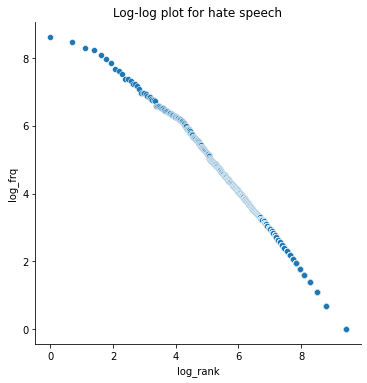

In [16]:
#Plotting to check consistency with Zipf's law for the hate speech data
hate_train_frq['log_frq'] = np.log(hate_train_frq.frequency)
hate_train_frq['log_rank'] = np.log(hate_train_frq.frequency.rank(ascending=False))
sns.relplot(x='log_rank', y='log_frq', data=hate_train_frq).set(title="Log-log plot for hate speech")
plt.show()

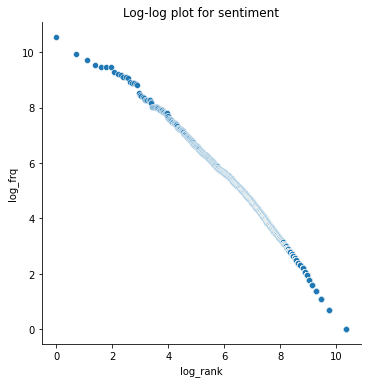

In [17]:
#Plotting to check consistency with Zipf's law for the sentiment data
senti_train_frq['log_frq'] = np.log(senti_train_frq.frequency)
senti_train_frq['log_rank'] = np.log(senti_train_frq.frequency.rank(ascending=False))
sns.relplot(x='log_rank', y='log_frq', data=senti_train_frq).set(title="Log-log plot for sentiment")
plt.show()

In [18]:
#Since the log-log plots mostly follow a straight descending line, with the exception of a few somewhat outliers
#in the top left, we conclude that the corpus statistics are consistent with Zipf's law.

<h2>Task 3 - Manual Annotation and Inter-Annotator Agreement<h2>

In [19]:
#We have chosen the sentiment training dataset for manual annotation and selected a subset of a 100 tweets
manual_annotation_tweets = senti_train[50:150]
manual_annotation_tweets
# 2 for positive, 1 for neutral and 0 for negative

['thanks manager for putting me on the schedule for sunday"',
 "i'm sat at work just laughing at all these hulk hogan tweets. hahha ffs",
 "@user #mlbcentral david wright crushing a dinger on his first swing since april 14th. i didn't think he would pull a wilmer flores!",
 'i feel like the new janet jackson single is bringing back 90s r&amp;b. via @user',
 'anyone want to see sam smith with me on october 6th?',
 'this friday outhouse is playing at still partners in sea cliff ! hop on the expressway to nirvana!',
 '"you can\'t shit talk kpop. every group is so in sync and vocally on point. it may not be your thing, but it\'s talent."',
 'i hope milan mom say that she can come over on the 28th',
 'don\\u2019t forget mitch daniels is going to be on steven colbert\\u2019s show thursday.  think this will come up as a topic?',
 "amazon prime is literally a lie....i ordered a book last monday &amp; it still isn't here. do better @user",
 'who the hell moshes at matt and kim?? next time watch

In [20]:
#Loading in each group members annotations along with the published labels
man_anno1 = read_file("/work/tweeteval/datasets/manual_annotation/ano.txt")
man_anno2 = read_file("/work/tweeteval/datasets/manual_annotation/man_anno.txt")
man_anno3 = read_file("/work/tweeteval/datasets/manual_annotation/man_anno_jr.txt")
man_anno4 = read_file("/work/tweeteval/datasets/manual_annotation/tweet.TXT")
data_anno = senti_train_labels[50:150]

#Creating a dictionary in order to create a dataframe
d = {'anno1':man_anno1,'anno2':man_anno2,'anno3':man_anno3,'anno4':man_anno4, 'true_labels':data_anno}
annotations = pd.DataFrame(data=d)
annotations




,anno1,anno2,anno3,anno4,true_labels
0,2,0,2,1,0
1,2,2,1,1,2
2,1,2,2,1,1
3,1,1,2,2,2
4,1,1,1,1,1
...,...,...,...,...,...
95,2,2,2,2,2
96,1,1,1,1,0
97,1,1,1,2,1
98,2,2,2,2,2


The Inter-Annotator Agreement(IAA) is a measurement of how well two or more annotators can take the same annotation decision for a specific category.  We have used Cohen's kappa coefficient which statistically measures the reliability between annotators for categorical data. It does take into account the possibility of the agreement to occur by pure chance. 

In [21]:
print("Cohen kappa score for the the first and second manual annotations is: ",  cohen_kappa_score(annotations['anno1'], annotations['anno2']))
print("Cohen kappa score for the the first and third manual annotations is: ",  cohen_kappa_score(annotations['anno1'], annotations['anno3']))
print("Cohen kappa score for the the first and fourth manual annotations is: ",  cohen_kappa_score(annotations['anno1'], annotations['anno4']))
print('The average of Cohen kappa score for the 4 manual annotations is:',round((cohen_kappa_score(annotations['anno1'], annotations['anno2']) + cohen_kappa_score(annotations['anno1'], annotations['anno3']) + cohen_kappa_score(annotations['anno1'], annotations['anno4']) + cohen_kappa_score(annotations['anno2'], annotations['anno3']) + cohen_kappa_score(annotations['anno2'], annotations['anno4']) + cohen_kappa_score(annotations['anno3'], annotations['anno4']))/6,4))

print('Cohen kappa score for the first and true labels annotations is: ',cohen_kappa_score(annotations['anno1'], annotations['true_labels']) )
print('Cohen kappa score for the second and true labels annotations is: ',  cohen_kappa_score(annotations['anno2'], annotations['true_labels']))
print('Cohen kappa score for the third and true labels is: ', cohen_kappa_score(annotations['anno3'], annotations['true_labels']))
print('Cohen kappa score for the fourth and true labels is:', cohen_kappa_score(annotations['anno4'], annotations['true_labels']))

Cohen kappa score for the the first and second manual annotations is:  0.5661228740020826
Cohen kappa score for the the first and third manual annotations is:  0.3666552550496406
Cohen kappa score for the the first and fourth manual annotations is:  0.3356047700170358
The average of Cohen kappa score for the 4 manual annotations is: 0.4299
Cohen kappa score for the first and true labels annotations is:  0.4479759116761459
Cohen kappa score for the second and true labels annotations is:  0.5140913508260447
Cohen kappa score for the third and true labels is:  0.47360025522411875
Cohen kappa score for the fourth and true labels is: 0.26140012845215155


The Cohen's kappa score for the 4 manual annotators and the test labels ranges from 0.2614 to .5140, while the average for the 4 gives .4299.  It is important to mention that the annotators did not take the same decision and the categories can not be strongly categorized since linguistics are hard for a machine to understand. In conclusion, the Cohen's kappa score ranging from .26 to .51 means a fair to moderate inter-annotator agreement. 

<h2>TASK 4 - Automatic Prediction <h2>

<h3>Features (Tf-Idf and POS-tags)<h3>

In [22]:
# stopwords = nltk.corpus.stopwords.words("english")

stemmer = PorterStemmer() # https://tartarus.org/martin/PorterStemmer/



def get_vectorizer_transform(docs, vectorizer, debug=False, nameOfVectorizer=""):
    M = vectorizer.transform(docs).toarray()
    if debug:
        print("Shape of M (",nameOfVectorizer,"):", M.shape)
    return M

def get_pos_tags(docs, vectorizer, debug=False):
    #Get POS tags for tweets and save as a string
    doc_tags = []
    for d in docs:
        tokens = tokenize(preprocess(d))
        tags = nltk.pos_tag(tokens)
        tag_list = [x[1] for x in tags]
        tag_str = " ".join(tag_list)
        doc_tags.append(tag_str)

    #Construct POS TF matrix and get vocab dict
    pos = vectorizer.transform(pd.Series(doc_tags)).toarray()
#     pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

    if debug:
        print("Shape of pos matrix: ", pos.shape)
    
    return pos

In [23]:
def generateFeatures(train_data, tokenizah, debug=False):
    # creating vectorizer for Tfidf
    # has stop words, doesn't have n-gram
    vectorizer1 = TfidfVectorizer(
        tokenizer=tokenizah,
        preprocessor=preprocess,
        stop_words="english", 
        use_idf=True,
        smooth_idf=False,
        norm=None, 
        decode_error='replace',
        max_features=10000,
        min_df=5,
        max_df=0.501
        ) 
    # has both stop words and n-gram
    vectorizer2 = TfidfVectorizer(
        tokenizer=tokenizah,
        preprocessor=preprocess,
        stop_words="english", 
        use_idf=True,
        smooth_idf=False,
        norm=None, 
        decode_error='replace',
        max_features=10000,
        min_df=5,
        max_df=0.501
        ) 

    #Using TFIDF vectorizer to get token matrix for POS tags 
    pos_vectorizer = TfidfVectorizer(
        tokenizer=None,
        lowercase=False,
        preprocessor=None,
        ngram_range=(1, 3),
        stop_words=None, 
        use_idf=False,
        smooth_idf=False,
        norm=None, 
        decode_error='replace',
        max_features=5000,
        min_df=5,
        max_df=0.501,
        )
    # fitting the vectorizer with the training tweets
    ####################### aggregate hate_train and senti_train to train these vectorizers and whatnot
    vectorizer1 = vectorizer1.fit(train_data) 
    vectorizer2 = vectorizer2.fit(train_data) 
#     tfidf_list = [vectorizer1, vectorizer2]

    #Get POS tags for tweets and save as a string
    doc_tags = []
    for d in train_data:
        tokens = tokenizah(preprocess(d))
        tags = nltk.pos_tag(tokens)
        tag_list = [x[1] for x in tags]
        tag_str = " ".join(tag_list)
        doc_tags.append(tag_str)
    # fitting the pos_vectorizer (to the tf-idf of word classes)        
    pos_vectorizer = pos_vectorizer.fit(pd.Series(doc_tags))

    # count vectorizer
    countvectorizer = CountVectorizer(tokenizer=tokenizah, ngram_range=(1, 3),decode_error='replace', stop_words='english')
    countvectorizer = countvectorizer.fit(train_data)
    
    ### generate several feature matrices and return them.
    # term frequency
    termfrequency = get_vectorizer_transform(train_data, countvectorizer, debug, "CountVectorizer")
    # Tf-Idf1
    tf_idf1 = get_vectorizer_transform(train_data, vectorizer1, debug, "Vectorizer1")
    # Tf-Idf2
    tf_idf2 = get_vectorizer_transform(train_data, vectorizer2, debug, "Vectorizer2")
    # POS tags 
    pos_tags = get_pos_tags(train_data, pos_vectorizer, debug)
    
    return (termfrequency, tf_idf1, tf_idf2, pos_tags)

In [24]:
hate_matlist = generateFeatures(hate_train, tokenize, True)
senti_matlist = generateFeatures(senti_train, tokenize, True)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
Shape of M ( CountVectorizer ): (9000, 180467)
Shape of M ( Vectorizer1 ): (9000, 3187)
Shape of M ( Vectorizer2 ): (9000, 3187)


KeyboardInterrupt: 

<h3>Model</h3>

In [ ]:
############ Building the model

####### need train tweets, train_classes and test tweets and test_classes...  #######
#### So M, M_, tweet_classes and test_tweet_classes don't exist. 

X_train = M
y_train = tweet_classes

X_test = M_
y_test = test_tweet_classes


#select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",solver='liblinear',C=0.01)) ##Meta-transformer for selecting features based on importance weights.
#X_ = select.fit_transform(X,y)

model = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr').fit(X_train, y_train)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)


NameError: name 'M' is not defined

In [ ]:
import random

in_data = 'tweeteval/datasets'
out_data = 'iaa_sets'

iaa_size = 100

corpora = [
    'hate' + '/', 
    'offensive' + '/',
    'sentiment' + '/'

]

for idx in corpora:
    indir = in_data + '/' + idx
    outdir = out_data + '/' + idx
    with open(indir + 'train_text.txt', 'r') as file:
        train_text = [line.rstrip('\n') for line in file]
    with open(indir + 'train_labels.txt', 'r') as file:
        train_labels = [line.rstrip('\n') for line in file]

    train_size = len(train_text)
    assert len(train_labels) == train_size

    smpl = set(random.sample(range(train_size), iaa_size))
    iaa_text = [t for i, t in enumerate(train_text) if i in smpl]
    iaa_labels = [t for i, t in enumerate(train_labels) if i in smpl]

    os.makedirs(outdir, exist_ok=True)
    with open(outdir + 'iaa_text.txt', 'w') as f:
        print('\n'.join(iaa_text), file = f)
    with open(outdir + 'iaa_labels.txt', 'w') as f:
        print('\n'.join(iaa_labels), file = f)
    with open(outdir + '/iaa_indices.txt', 'w') as f:
        print('\n'.join(str(i) for i in sorted(smpl)), file = f)


In [ ]:
print(cohen_kappa_score(annotations['anno3'], annotations['anno4']))

0.2752456112095346


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=247de330-31de-47dd-b667-0f24ec91303c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>